<h1><center>Лабораторная работа № 3</center></h1>
<h3><center>"Линейная регрессия"</center></h3>

Необходимо решить задачу предсказания стоимости дома в зависимости от его характеристик. Задача решается в рамках платформы онлайн-конкурсов по машинному обучению Kaggle. Ссылка на задание.

Рекомендуется перед выполнением задания изучить отличный туториал, предоставляемый на сайте. В нем разбирается задача классификации, что соответствует лабораторной работе №4, но все действия связанные с подготовкой данных полностью актуальны для этой лабораторной работы.

**1\. Провести предподготовку данных**

Перед выполнением этого пункта рекомендуется посмотреть лекцию по Pandas.

(Обязательно) Необходимо перевести категориальные фичи в числовые, отмасштабировать показатели для лучшей обучаемости модели при необходимости (можно провести эксперименты, как это будет влиять на результаты модели). Построить графики по распределнию площадей домой и распределнию цен. Для реализации этой части использовать библиотеки pandas и matplotlib и seaborn.

Необходимо оценить предоставляемые данные, на свое усмотрение предположить несколько возможных зависимостей между признаками и предсказываемыми значениями, проверить гипотезы, построив необходимые графики.

По возможности можно определить, какие признаки являются незначимыми или их доля мала, и объединить такие признаки с другими.

Создать несколько собственных фич на основе своих эвристик и оценить, влияют ли они на качество модели.

Результатом выполнения этого пункта является блок ячеек или скрипт предобработки данных.

**2\. Разделить данные**

В этом пункте необходимо поделить данные на обучающую и валидационную выборку. Для этого можно использовать train_test_split. Делить можно в соотношениях 70-90 / 30-10 % соответственно.

**3\. Обучить модель из sklearn**

Следующим шагом необходимо обучить модель линейной регрессии. Для этого нужно использовать класс LinearRegression из sklearn.

Получить предсказания модели на валидационной части выборки. Оценить результат по метрике Mean Absolute Error (MAE) и по метрике, используемой для оценки результатов этого конкурса на kaggle.

**4\. Реализовать линейную регрессию**

На этом шаге необходимо реализовать модель линейной регрессии, используя python самостоятельно. Для этого изначально можно попробовать написать алгоритм для одного обучаемого параметра, а затем написать реализацию общего случая, используя сначала циклы, а затем векторные вычисления из библиотеку numpy. Если есть полное понимание, как нужно реализовать алгоритм для множества обучаемых параметров с использованием векторизации вычислений - можно сразу делать так, главное на защите уметь объяснить.

**5\. Эксперименты с моделью**

На этом шаге вы уже имеете базовую модель, которая делает предсказания. Необходимо прогнать модель на тестовой выборке и отправить решение на kaggle. После этого можно улучшать свой результат, экспериментируя с подготовкой данных и параметрами модели. Рекомендуется смотреть т.н. kernel'ы на kaggle - раздел, где участники соревнований выкладывают код со своими идеями и реализациями. Это может быть очень полезно, как для обучения, так и для реализации новых идей.
* Студент, получивший максимальное место на kaggle среди участников из своей группы получает автомат за весь курс.

Базовый пример реализации приведен в ноутбуке example.
Заметки

    При прогоне модели из example, где нет нормировок и используются всего 3 фичи, был получен результат в mae ~ 57к и rmsle ~ 0.409.
    При использовании почти всех фич из выборки mae сократилось до 24к, а rmsle до 0.29
    При замене NaN в фичах можно подставлять наиболее частое значение по фиче из выборки
    Использование всех фич без разбора иногда ухудшает результат
    При переводе качественных фич в цифровые значения и нормализации непрерывных величин удобно написать небольшую функцию и применить ее для всех фич.


### Решение:

# Импортирование модулей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import tqdm

from pathlib import Path
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import cm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import ensemble

####  Подключаем встроенное построение графиков при помощи jupyter notebook

In [2]:
%matplotlib inline

# Константы

In [3]:
COMPETITION_FOLDER_PATH = '/home/glebdom4/.kaggle/competitions/house-prices-advanced-regression-techniques'
DATASET_TRAIN_FILE_NAME = 'train.csv'
DATASET_TEST_FILE_NAME = 'test.csv'
SUBMISSION_FILE_NAME = 'house_prices_submission.csv'

MATPLOTLIB_PLOT_STYLE = 'ggplot'
CUSTOM_FONT_NAME = 'PT Sans'
CUSTOM_FONT_SIZE = 12
CUSTOME_FIGURE_SIZE = (8, 6)

# PD_READ_CSV_NA_VALUES = ['NA',]
PD_READ_CSV_INDEX_COL = 0  # 'Id' column
PD_DATA_HEAD_SIZE = 5  # default value
PD_DATA_TAIL_SIZE = 5  # default value
PD_TARGET_VARIABLE_COLUMN_NAME = 'SalePrice'

SKLEARN_TEST_SPLIT_TEST_SIZE = 0.3
SKLEARN_TEST_SPLIT_RANDOM_STATE = 13
SKLEARN_USED_CPUS_COUNT = -1  # all
SKLEARN_RANDOM_FOREST_CLASSIFIER_RANDOM_STATE = 13
SKLEARN_RANDOM_FOREST_CLASSIFIER_N_ESTIMATORS = 100

# Настройка стиля графиков

In [4]:
plt.style.use(MATPLOTLIB_PLOT_STYLE)

# Загрузка данных

In [5]:
data_folder = Path(COMPETITION_FOLDER_PATH)

file_to_open = data_folder / DATASET_TRAIN_FILE_NAME
df = pd.read_csv(file_to_open, index_col=PD_READ_CSV_INDEX_COL)

file_to_open = data_folder / DATASET_TEST_FILE_NAME
df_test = pd.read_csv(file_to_open, index_col=PD_READ_CSV_INDEX_COL)

# Анализ данных

In [6]:
df.shape

(1460, 80)

In [7]:
df.head(PD_DATA_HEAD_SIZE)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
df.tail(PD_DATA_TAIL_SIZE)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [9]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Графики по распределению площадей домов и распределению цен:

In [10]:
mp = pd.DataFrame({'MedianPrice': df.groupby('YrSold')['SalePrice'].median()}).reset_index()
mp

,YrSold,MedianPrice
0,2006,163995
1,2007,167000
2,2008,164000
3,2009,162000
4,2010,155000


In [11]:
def thousands(x, pos):
    """The two args are the value and tick position"""
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

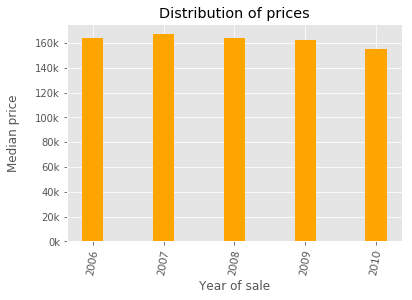

In [12]:
years = mp['YrSold'].tolist()
x_pos = np.arange(len(years))

median_prices = mp['MedianPrice'].tolist()

plt.bar(left=x_pos, height=median_prices, width=0.3, color='orange')
plt.xticks(x_pos, years, rotation=80, fontname=CUSTOM_FONT_NAME, fontsize=CUSTOM_FONT_SIZE)
plt.xlabel('Year of sale')
plt.ylabel('Median price', labelpad=15)
plt.title('Distribution of prices')

axis = plt.gca()
axis.yaxis.set_major_formatter(formatter)

plt.rcParams['figure.figsize'] = CUSTOME_FIGURE_SIZE

In [13]:
mp = pd.DataFrame({'MedianPrice': df.groupby('MoSold')['SalePrice'].median()}).reset_index()
mp

,MoSold,MedianPrice
0,1,151650
1,2,173250
2,3,165250
3,4,147000
4,5,154000
5,6,163000
6,7,165195
7,8,174450
8,9,185900
9,10,159000


In [14]:
ma = pd.DataFrame({'MedianArea': df.groupby('MoSold')['GrLivArea'].median()}).reset_index()
ma

,MoSold,MedianArea
0,1,1402.5
1,2,1487.0
2,3,1409.0
3,4,1386.0
4,5,1368.5
5,6,1478.0
6,7,1480.5
7,8,1504.0
8,9,1582.0
9,10,1414.0


In [15]:
ma = pd.merge(ma, mp, on='MoSold')
ma['MoSold'] = ma['MoSold'].apply(func=lambda x : calendar.month_name[x])
ma

,MoSold,MedianArea,MedianPrice
0,January,1402.5,151650
1,February,1487.0,173250
2,March,1409.0,165250
3,April,1386.0,147000
4,May,1368.5,154000
5,June,1478.0,163000
6,July,1480.5,165195
7,August,1504.0,174450
8,September,1582.0,185900
9,October,1414.0,159000


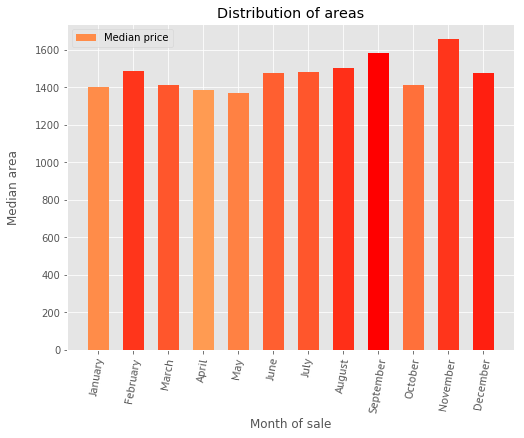

In [16]:
months = ma['MoSold'].tolist()
x_pos = np.arange(len(months))

median_areas = ma['MedianArea'].tolist()
median_prices = ma['MedianPrice'].tolist()

colors = cm.rainbow(np.array(median_prices) / max(median_prices))

plt.bar(left=x_pos, height=median_areas, width=0.6, color=colors)
plt.xticks(x_pos, months, rotation=80, fontname=CUSTOM_FONT_NAME, fontsize=CUSTOM_FONT_SIZE)
plt.xlabel('Month of sale')
plt.ylabel('Median area', labelpad=15)
plt.title('Distribution of areas')
plt.legend(['Median price'])

plt.rcParams['figure.figsize'] = CUSTOME_FIGURE_SIZE

# Подготовка данных

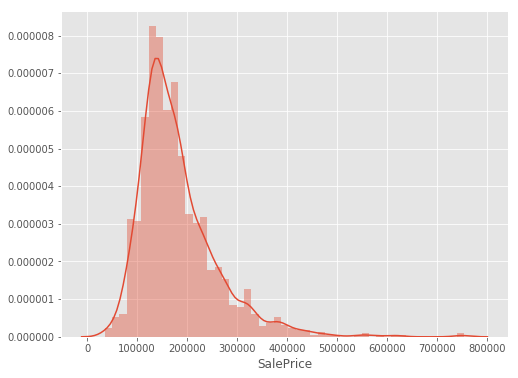

In [17]:
ax = sns.distplot(df[PD_TARGET_VARIABLE_COLUMN_NAME])

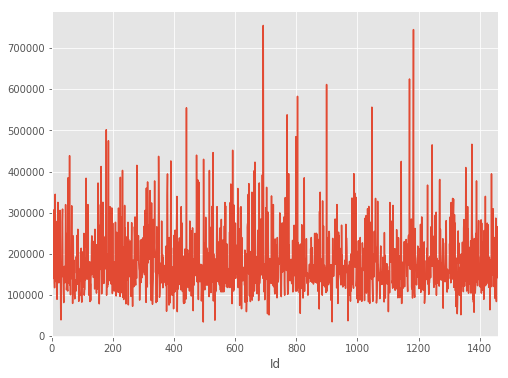

In [18]:
df[PD_TARGET_VARIABLE_COLUMN_NAME].plot()

In [19]:
df[PD_TARGET_VARIABLE_COLUMN_NAME] = df[PD_TARGET_VARIABLE_COLUMN_NAME].apply(np.log)

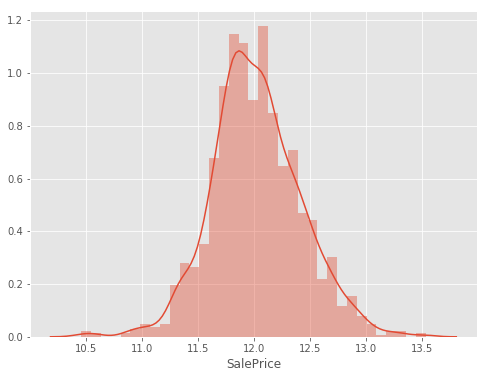

In [20]:
ax = sns.distplot(df[PD_TARGET_VARIABLE_COLUMN_NAME])

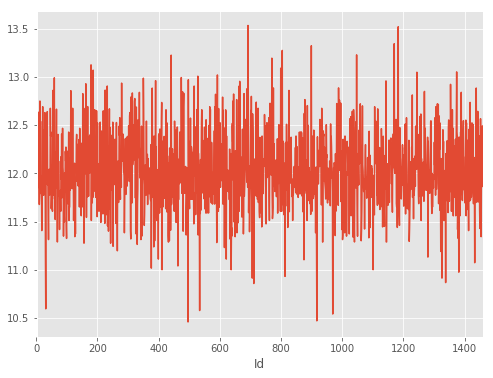

In [21]:
df[PD_TARGET_VARIABLE_COLUMN_NAME].plot()

### Удалим строки, чьи значения выделенного признака сильно оличаются от значений большинства строк:

In [22]:
df = df[df[PD_TARGET_VARIABLE_COLUMN_NAME] > 11] 
df = df[df[PD_TARGET_VARIABLE_COLUMN_NAME] < 13]  

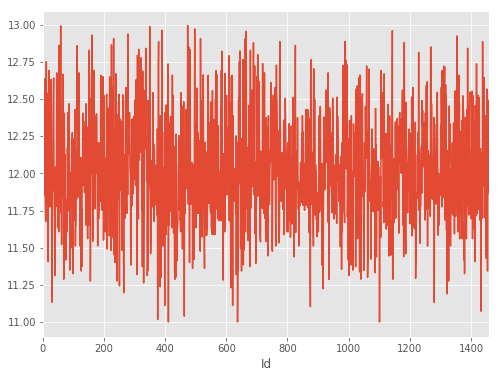

In [23]:
df[PD_TARGET_VARIABLE_COLUMN_NAME].plot()

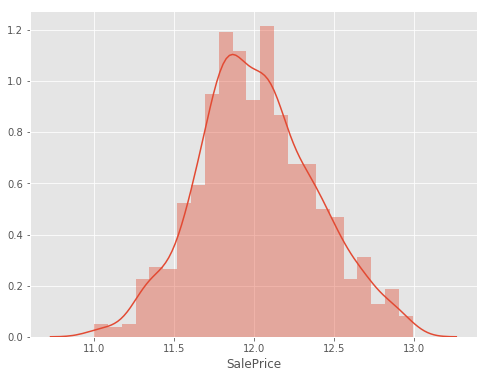

In [24]:
ax = sns.distplot(df[PD_TARGET_VARIABLE_COLUMN_NAME])

In [25]:
df.shape

(1434, 80)

### Для удобства  будем отдельно рассматривать столбцы, соответствующие входным признакам (матрица X), а отдельно – выделенный признак (вектор y):

In [26]:
X = df.drop((PD_TARGET_VARIABLE_COLUMN_NAME), axis=1)
y = df[PD_TARGET_VARIABLE_COLUMN_NAME]

In [27]:
X.shape

(1434, 79)

In [28]:
y.shape

(1434,)

### Проверим наличие незаполненных элементов и узнаем их количество:

In [29]:
X.isnull().values.any()

True

In [30]:
y.isnull().values.any()

False

In [31]:
NAs = pd.concat([X.isnull().sum(), X.dtypes], axis=1)
NAs.columns = ['NAs count', 'dtype']
NAs[NAs.sum(axis=1) > 0]

,NAs count,dtype
LotFrontage,258,float64
Alley,1346,object
MasVnrType,7,object
MasVnrArea,7,float64
BsmtQual,35,object
BsmtCond,35,object
BsmtExposure,36,object
BsmtFinType1,35,object
BsmtFinType2,36,object
Electrical,1,object


### Исправим типы и значения некоторыех параметров:

In [32]:
for col in X:
    if X[col].dtype != 'object':
        print('{0}: {1}'.format(col, X[col].dtype, sep=', '))

MSSubClass: int64
LotFrontage: float64
LotArea: int64
OverallQual: int64
OverallCond: int64
YearBuilt: int64
YearRemodAdd: int64
MasVnrArea: float64
BsmtFinSF1: int64
BsmtFinSF2: int64
BsmtUnfSF: int64
TotalBsmtSF: int64
1stFlrSF: int64
2ndFlrSF: int64
LowQualFinSF: int64
GrLivArea: int64
BsmtFullBath: int64
BsmtHalfBath: int64
FullBath: int64
HalfBath: int64
BedroomAbvGr: int64
KitchenAbvGr: int64
TotRmsAbvGrd: int64
Fireplaces: int64
GarageYrBlt: float64
GarageCars: int64
GarageArea: int64
WoodDeckSF: int64
OpenPorchSF: int64
EnclosedPorch: int64
3SsnPorch: int64
ScreenPorch: int64
PoolArea: int64
MiscVal: int64
MoSold: int64
YrSold: int64


In [33]:
# MSSubClass to categorical
X['MSSubClass'] = X['MSSubClass'].astype(str)

# OverallQual to categorical
X['OverallQual'] = X['OverallQual'].astype(str)

# OverallCond to categorical
X['OverallCond'] = X['OverallCond'].astype(str)

# YearBuilt to categorical
X['YearBuilt'] = X['YearBuilt'].astype(str)

# YearRemodAdd to categorical
X['YearRemodAdd'] = X['YearRemodAdd'].astype(str)

# GarageYrBlt to categorical
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0.0)
X['GarageYrBlt'] = X['GarageYrBlt'].astype(int).astype(str)

# Year and Month to categorical
X['YrSold'] = X['YrSold'].astype(str)
X['MoSold'] = X['MoSold'].astype(str)

# KitchenAbvGr to categorical
X['KitchenAbvGr'] = X['KitchenAbvGr'].astype(str)

# NA means no access
X['Alley'] = X['Alley'].fillna('NOACCESS')

# NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X[col] = X[col].fillna('NoBSMT')

# NA means No Fireplace
X['FireplaceQu'] = X['FireplaceQu'].fillna('NoFP')

# NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    X[col] = X[col].fillna('NoGRG')

# NA means No Pool
X['PoolQC'] = X['PoolQC'].fillna('NoP')

# NA means no Fence
X['Fence'] = X['Fence'].fillna('NoF')

# NA means None
X['MiscFeature'] = X['MiscFeature'].fillna('None')

### Удалим те параметры, количество пустых значений которых больше 50%:

In [34]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    
    return round(num / den, 2)

In [35]:
bad_na_features = []

for name, _ in X.iteritems():
    if get_percentage_missing(X[name]) > 0.5:
        bad_na_features.append(name)

In [36]:
bad_na_features = []

for name, _ in X.iteritems():
    if get_percentage_missing(X[name]) > 0.3:
        bad_na_features.append(name)

In [37]:
bad_na_features

[]

In [38]:
X = X.drop(bad_na_features, axis=1)

In [39]:
X.shape

(1434, 79)

In [40]:
NAs = pd.DataFrame(X.isnull().sum(), columns=['NAs count'])
NAs[NAs.sum(axis=1) > 0]

,NAs count
LotFrontage,258
MasVnrType,7
MasVnrArea,7
Electrical,1


### Заполним пропущенные значения:

#### Для количественных признаков:

In [41]:
X['LotFrontage'] = X['LotFrontage'].fillna(X['LotFrontage'].mean())
X['MasVnrArea'] = X['MasVnrArea'].fillna(X['MasVnrArea'].mean())

#### Для категориальных признаков:

In [42]:
data_describe = X.describe(include=[object])
X['MasVnrType'] = X['MasVnrType'].fillna(data_describe['MasVnrType']['top'])
X['Electrical'] = X['Electrical'].fillna(data_describe['Electrical']['top'])

### Проверим наличие незаполненных элементов:

In [43]:
X.isnull().values.any()

False

### Добавим новый парамер TotalSF,  объединяющий параметры Basement, 1st and 2nd floor.

In [44]:
# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

### Выделим числовые и категориальные признаки:

In [45]:
categorical_columns = [c for c in X.columns if X[c].dtype.name == 'object']
numerical_columns   = [c for c in X.columns if X[c].dtype.name != 'object']

In [46]:
print(categorical_columns)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [47]:
len(categorical_columns)

52

In [48]:
print(numerical_columns)

['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'TotalSF']


In [49]:
len(numerical_columns)

25

### Определим полный перечень значений категориальных признаков:

In [50]:
for c in categorical_columns:
    print('{0}: {1}'.format(c, X[c].unique()))

MSSubClass: ['60' '20' '70' '50' '190' '45' '90' '120' '30' '85' '80' '160' '75' '180'
 '40']
MSZoning: ['RL' 'RM' 'FV' 'C (all)' 'RH']
Street: ['Pave' 'Grvl']
Alley: ['NOACCESS' 'Grvl' 'Pave']
LotShape: ['Reg' 'IR1' 'IR2' 'IR3']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities: ['AllPub' 'NoSeWa']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope: ['Gtl' 'Mod' 'Sev']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
OverallQual: ['7' '6' '8' '5' '9' '4' '10' '3' '1' '2']
OverallCo

## Преобразуем категориальные признаки в количественные:

### Выделим бинарные и небинарные признаки:

In [51]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]

In [52]:
print(binary_columns)

['Street', 'Utilities', 'CentralAir']


In [53]:
print(nonbinary_columns )

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


### Значения бинарных признаков заменим на 0 и 1:

In [54]:
for c in binary_columns:
    top = data_describe[c]['top']
    top_items = X[c] == top
    X.loc[top_items, c] = 0
    X.loc[np.logical_not(top_items), c] = 1

In [55]:
X[binary_columns].describe()

,Street,Utilities,CentralAir
count,1434,1434,1434
unique,2,2,2
top,0,0,0
freq,1429,1433,1349


### К небинарными признакам применим метод векторизаци:

In [56]:
# data_nonbinary = pd.get_dummies(X[nonbinary_columns])

In [57]:
# data_nonbinary.columns

### Небинарные признаки переведём в числа:

In [58]:
data_nonbinary = X[nonbinary_columns]
for c in data_nonbinary:
    data_nonbinary[c] = data_nonbinary[c].factorize()[0]

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Стандартизируем значения числовых входных признаков:

In [59]:
data_numerical = X[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()

In [60]:
data_numerical.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalSF
count,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,...,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03,1.434000e+03
mean,-1.183630e-14,7.156642e-17,6.124034e-16,9.445412e-18,8.872494e-17,-9.112500e-17,-4.782127e-16,-2.180961e-16,-1.173709e-16,-2.441871e-16,...,1.820952e-16,3.375573e-17,-4.149788e-17,-7.629880e-17,-9.468638e-17,-7.136512e-16,-2.520841e-16,-2.737428e-16,-1.914244e-17,2.385499e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.243873e+00,-9.190811e-01,-5.819738e-01,-9.832166e-01,-2.899835e-01,-1.285101e+00,-1.188277e-01,-2.140587e+00,-8.178840e-01,-2.416723e-01,...,-2.409462e+00,-2.255741e+00,-7.532565e-01,-7.089580e-01,-3.587400e-01,-1.173627e-01,-2.680081e-01,-6.403554e-02,-8.492819e-02,-2.355110e+00
25%,-4.506513e-01,-2.921436e-01,-5.819738e-01,-9.832166e-01,-2.899835e-01,-7.845855e-01,-1.188277e-01,-7.477691e-01,-8.178840e-01,-2.416723e-01,...,-1.043783e+00,-6.493422e-01,-7.532565e-01,-7.089580e-01,-3.587400e-01,-1.173627e-01,-2.680081e-01,-6.403554e-02,-8.492819e-02,-6.891832e-01
50%,-1.176148e-14,-9.897716e-02,-5.819738e-01,-1.227050e-01,-2.899835e-01,-2.079420e-01,-1.188277e-01,-9.397724e-02,-8.178840e-01,-2.416723e-01,...,3.218965e-01,2.955253e-02,-7.532565e-01,-3.379363e-01,-3.587400e-01,-1.173627e-01,-2.680081e-01,-6.403554e-02,-8.492819e-02,-1.017196e-01
75%,3.769894e-01,1.049821e-01,3.528481e-01,5.983097e-01,-2.899835e-01,5.510685e-01,-1.188277e-01,5.267240e-01,1.107971e+00,-2.416723e-01,...,3.218965e-01,4.980855e-01,5.936286e-01,3.345405e-01,-3.587400e-01,-1.173627e-01,-2.680081e-01,-6.403554e-02,-8.492819e-02,5.654873e-01
max,1.118230e+01,2.056064e+01,8.722630e+00,1.166451e+01,8.801021e+00,4.023428e+00,1.118259e+01,8.296018e+00,4.959681e+00,8.109124e+00,...,3.053255e+00,4.523644e+00,6.117461e+00,7.747245e+00,8.636100e+00,1.705729e+01,8.513604e+00,1.944887e+01,3.140821e+01,1.183405e+01


In [61]:
# ax = sns.pairplot(data_numerical)

## Соединим все столбцы в одну таблицу:

In [62]:
X = pd.concat((data_numerical, X[binary_columns], data_nonbinary), axis=1)
X = pd.DataFrame(X, dtype=float)

In [63]:
X.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

In [64]:
X.shape

(1434, 53)

In [65]:
y.shape

(1434,)

In [66]:
X.head()

,LotFrontage,LotArea,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,TotalSF,...,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageQual,PavedDrive,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.220751,-0.201233,0.410405,0.811495,1.231877,0.159989,0.956487,-0.950766,0.321896,0.019182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.468949,-0.085775,-0.488057,0.811495,-0.757438,0.159989,-0.312340,0.610973,0.321896,-0.034838,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,-0.082811,0.079882,0.562823,0.811495,1.231877,0.159989,-0.312340,0.610973,0.321896,0.199247,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,-0.450651,-0.090795,0.424444,-1.032695,-0.757438,0.159989,0.322073,0.610973,1.687576,-0.100433,...,0.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0
5,0.652870,0.382082,1.389088,0.811495,1.231877,1.393453,1.590901,0.610973,1.687576,1.018545,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [67]:
df = pd.concat([X, y], axis=1)

In [68]:
df.to_csv("df_train.csv")

In [69]:
feature_names = X.columns

In [70]:
df.shape

(1434, 54)

In [71]:
#fig, ax = plt.subplots(figsize=(30, 30))
#sns.heatmap(df.corr(), ax=ax)
target_feature_corr = df.corr().loc[PD_TARGET_VARIABLE_COLUMN_NAME].sort_values(ascending=False)
for feature, val in target_feature_corr.iteritems():
    print('{0}: {1}'.format(feature, val))

SalePrice: 1.0
TotalSF: 0.7575948544489637
GrLivArea: 0.67632912961
GarageCars: 0.6645185249227358
FullBath: 0.5815680798179793
TotRmsAbvGrd: 0.49861246571843293
Fireplaces: 0.47442155253092294
FireplaceQu: 0.3984713453141939
LotFrontage: 0.3248688874779222
HalfBath: 0.29505437525366957
LotShape: 0.28309207070552694
LotArea: 0.24383158650290265
BedroomAbvGr: 0.19006508903627564
RoofStyle: 0.13213033659183826
BsmtExposure: 0.11574886186598661
SaleCondition: 0.10410901209356631
LotConfig: 0.10249591771544542
LandContour: 0.09225787719751606
LandSlope: 0.06201676960399362
SaleType: 0.029975438093036776
MoSold: -0.01212518848917669
Condition2: -0.013456617915008916
YearRemodAdd: -0.029285413476476823
YrSold: -0.029559690385830006
Street: -0.033427089846403114
Condition1: -0.04320769425494892
MasVnrType: -0.06288192766132901
BsmtFinType2: -0.07350002832767329
Alley: -0.07391902329987872
GarageFinish: -0.0806808200945182
BldgType: -0.11091737327880732
ExterCond: -0.14457648093898484
Exterior

# Обучающая и тестовая выборки

### Разобьём данные на обучающую/тестовую выборки в отношении
#### $ (1 - $ SKLEARN_TEST_SPLIT_TEST_SIZE$)$  :  SKLEARN_TEST_SPLIT_TEST_SIZE (70% :  30%):

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = SKLEARN_TEST_SPLIT_TEST_SIZE,
                                                    random_state = SKLEARN_TEST_SPLIT_RANDOM_STATE)

In [73]:
n_train, _ = X_train.shape 
n_test,  _ = X_test.shape 
print(n_train)
print(n_test)

1003
431


In [74]:
print(y_train.shape[0])
print(y_test.shape[0])

1003
431


# Обучение модели из sklearn 

### Отберём признаки (Feature Selection) с помощью алгоритма случайного леса:

In [75]:
rf = ensemble.RandomForestRegressor(n_estimators=SKLEARN_RANDOM_FOREST_CLASSIFIER_N_ESTIMATORS, 
                                     random_state=SKLEARN_RANDOM_FOREST_CLASSIFIER_RANDOM_STATE)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [76]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

In [77]:
print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'TotalSF' (0.6478)
 2. feature 'GarageCars' (0.0389)
 3. feature 'OverallQual' (0.0328)
 4. feature 'ExterQual' (0.0291)
 5. feature 'KitchenAbvGr' (0.0221)
 6. feature 'GrLivArea' (0.0184)
 7. feature 'LotArea' (0.0177)
 8. feature 'BsmtQual' (0.0170)
 9. feature 'Foundation' (0.0148)
10. feature 'BsmtFinType1' (0.0139)
11. feature 'OverallCond' (0.0118)
12. feature 'Neighborhood' (0.0110)
13. feature 'KitchenQual' (0.0093)
14. feature 'LotFrontage' (0.0089)
15. feature 'YearBuilt' (0.0061)
16. feature 'YearRemodAdd' (0.0061)
17. feature 'HeatingQC' (0.0060)
18. feature 'SaleCondition' (0.0060)
19. feature 'MoSold' (0.0059)
20. feature 'MSSubClass' (0.0051)
21. feature 'GarageQual' (0.0042)
22. feature 'FireplaceQu' (0.0040)
23. feature 'Exterior1st' (0.0038)
24. feature 'BedroomAbvGr' (0.0037)
25. feature 'Exterior2nd' (0.0037)
26. feature 'FullBath' (0.0036)
27. feature 'YrSold' (0.0035)
28. feature 'GarageType' (0.0033)
29. feature 'BsmtExposure' (0

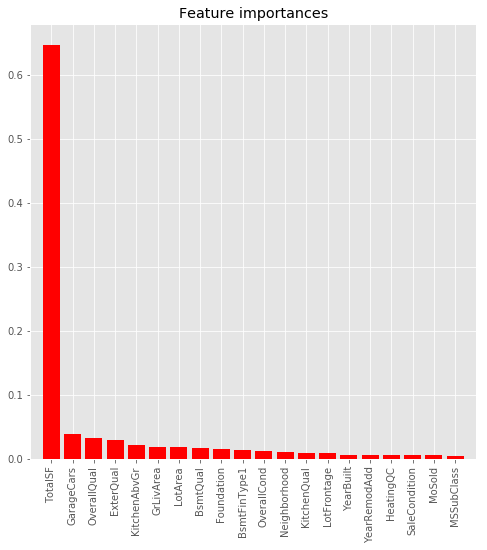

In [78]:
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center', color='red')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [79]:
analyze_x = []
analyze_y = []
for f in np.arange(1, 200, 1):
    best_features = np.array(feature_names)[indices[:f]]
    best_X = X[best_features]
    best_X_train, best_X_test, best_y_train, best_y_test = train_test_split(best_X, y,
                                                                            test_size = SKLEARN_TEST_SPLIT_TEST_SIZE,
                                                                            random_state = SKLEARN_TEST_SPLIT_RANDOM_STATE)
    clf = LinearRegression(n_jobs=SKLEARN_USED_CPUS_COUNT)
    clf.fit(best_X_train, best_y_train)
    predicted_best_y_test = clf.predict(best_X_test)
    
    analyze_x.append(f)
    analyze_y.append(metrics.mean_absolute_error(np.exp(best_y_test), np.exp(predicted_best_y_test)))

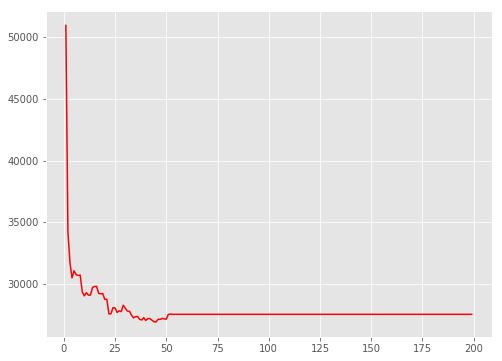

In [80]:
plt.plot(analyze_x, analyze_y, color='red')
plt.show()

In [81]:
min_mae, idx = min((val, idx) for (idx, val) in enumerate(analyze_y))

In [82]:
min_mae

26943.499000954023

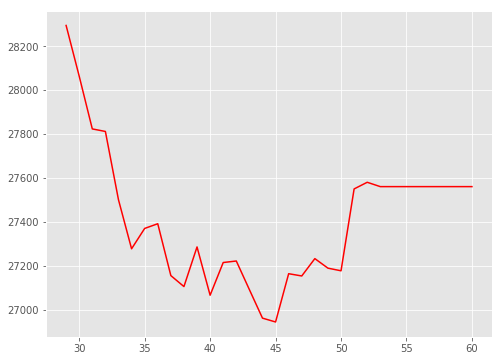

In [83]:
plt.plot(analyze_x[idx-16:idx+16], analyze_y[idx-16:idx+16], color='red')
plt.show()

In [84]:
best_X = X[best_features[0:idx+1]]
best_X_train, best_X_test, best_y_train, best_y_test = train_test_split(best_X, y,
                                                                            test_size = SKLEARN_TEST_SPLIT_TEST_SIZE,
                                                                            random_state = SKLEARN_TEST_SPLIT_RANDOM_STATE)
model = LinearRegression(n_jobs=SKLEARN_USED_CPUS_COUNT)
model.fit(best_X_train, best_y_train)
predicted_best_y_test = model.predict(best_X_test)

In [85]:
mae = metrics.mean_absolute_error(np.exp(best_y_test), np.exp(predicted_best_y_test))

In [86]:
mae

26943.499000954023

In [87]:
rmsle_best_test = np.sqrt(metrics.mean_squared_log_error(np.exp(best_y_test), np.exp(predicted_best_y_test)))

In [88]:
rmsle_best_test

0.21095854829520888

## Реализация линейной регрессии

In [89]:
class LinRegression:
    """Линейная регрессия."""
    def __init__(self):
        self.w = []
    
    def computeCost(self, X, y):
        tobesummed = np.power(((X @ self.w.T)-y),2)
        return np.sum(tobesummed)/(2 * len(X))
    
    def fit(self, X, y, iters=3000, alpha=0.99):
        "(Градиентный спуск.)"
        ones = np.ones([X.shape[0],1])
        X = np.hstack((ones,X))                          
        y = y.values
        self.w = np.array([-1.0] * X.shape[1])
        
        cost0 = self.computeCost(X, y)
        
        for i in range(iters):
            w_tmp = self.w
            self.w -= (alpha/X.shape[0]) * np.dot(X.T, (X @ self.w.T - y))
            cost = self.computeCost(X, y)
            
            if (cost > cost0):
                self.w = w_tmp
                break
    def fit2(self, X, y):
        ones = np.ones([X.shape[0],1])
        X = np.hstack((ones,X))                          
        y = y.values
        
        self.w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    
    def fit3(self, X, y):
        """(QR разложение.)"""
        ones = np.ones([X.shape[0],1])
        X = np.hstack((ones,X))                          
        y = y.values
        
        q, r = np.linalg.qr(X)
        self.w = np.dot(np.dot(np.linalg.inv(r), q.T), y)
        
    def fit4(self, X, y, lmbd=0.1):
        """Ridge regression (гребневая регрессия)."""
        ones = np.ones([X.shape[0],1])
        X = np.hstack((ones,X))                          
        y = y.values
        
        w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X) + lmbd * np.eye(X.shape[1])), X.T), y)
        
    def fit5(self, X, y, iters=3000, alpha=0.99, lmbd=0.1):
        "Lasso."
        ones = np.ones([X.shape[0],1])
        X = np.hstack((ones,X))                          
        y = y.values
        self.w = np.array([-1.0] * X.shape[1])
        
        cost0 = self.computeCost(X, y)
        
        for i in range(iters):
            w_tmp = self.w
            self.w -= (alpha/X.shape[0]) * np.dot(X.T, (X @ self.w.T - y)) + lmbd * np.sign(self.w)
            cost = self.computeCost(X, y)
            
            if (cost > cost0):
                self.w = w_tmp
                break

    def predict(self, X):
        ones = np.ones([X.shape[0],1])
        return np.dot(np.hstack((ones, X)), self.w)

In [90]:
def calc_mae(y_true, y_pred):
    mae = metrics.mean_absolute_error(y_true, y_pred)
    return mae

In [91]:
my_model = LinRegression()
my_model.fit(best_X_train, best_y_train, iters=24000, alpha=0.01)

In [92]:
my_y_predicted = my_model.predict(best_X_test)

In [94]:
calc_mae(best_y_test, my_y_predicted)  # without exp

2643.3520224932158

In [95]:
my_model.fit2(best_X_train, best_y_train)
my_y_predicted = my_model.predict(best_X_test)

In [97]:
calc_mae(np.exp(best_y_test), np.exp(my_y_predicted))

26943.499000954111

In [98]:
my_model.fit3(best_X_train, best_y_train)
my_y_predicted = my_model.predict(best_X_test)

In [101]:
calc_mae(np.exp(best_y_test), np.exp(my_y_predicted))

26943.499000953943

In [102]:
my_model.fit4(best_X_train, best_y_train)
my_y_predicted = my_model.predict(best_X_test)

In [103]:
calc_mae(np.exp(best_y_test), np.exp(my_y_predicted))

26943.499000953943

In [104]:
my_model.fit5(best_X_train, best_y_train, iters=12000, alpha=0.1, lmbd=10)
my_y_predicted = my_model.predict(best_X_test)

In [106]:
calc_mae(best_y_test, my_y_predicted)  # without exp

28516.842941043556

## Подготовка решения для отправки на kaggle:

In [150]:
def process_data(X):

    # MSSubClass to categorical
    X['MSSubClass'] = X['MSSubClass'].astype(str)

    # OverallQual to categorical
    X['OverallQual'] = X['OverallQual'].astype(str)

    # OverallCond to categorical
    X['OverallCond'] = X['OverallCond'].astype(str)

    # YearBuilt to categorical
    X['YearBuilt'] = X['YearBuilt'].astype(str)

    # YearRemodAdd to categorical
    X['YearRemodAdd'] = X['YearRemodAdd'].astype(str)

    # GarageYrBlt to categorical
    X['GarageYrBlt'] = X['GarageYrBlt'].fillna(0.0)
    X['GarageYrBlt'] = X['GarageYrBlt'].astype(int).astype(str)

    # Year and Month to categorical
    X['YrSold'] = X['YrSold'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)

    # KitchenAbvGr to categorical
    X['KitchenAbvGr'] = X['KitchenAbvGr'].astype(str)

    # NA means no access
    X['Alley'] = X['Alley'].fillna('NOACCESS')

    # NA means No basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        X[col] = X[col].fillna('NoBSMT')

    # NA means No Fireplace
    X['FireplaceQu'] = X['FireplaceQu'].fillna('NoFP')

    # NA means No Garage
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        X[col] = X[col].fillna('NoGRG')

    # NA means No Pool
    X['PoolQC'] = X['PoolQC'].fillna('NoP')

    # NA means no Fence
    X['Fence'] = X['Fence'].fillna('NoF')

    # NA means None
    X['MiscFeature'] = X['MiscFeature'].fillna('None')
    
    X = X.fillna(X.median(axis=0), axis=0)
    
    data_describe = X.describe(include=[object])
    for c in X.columns:
        if X[c].dtype == object:
            X[c] = X[c].fillna(data_describe[c]['top'])
    
    X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    X.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
    
    categorical_columns = [c for c in X.columns if X[c].dtype.name == 'object']
    numerical_columns   = [c for c in X.columns if X[c].dtype.name != 'object']

    # Выделяем бинарные и небинарные признаки.
    binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
    nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] != 2]

    for c in binary_columns:
        top = data_describe[c]['top']
        top_items = X[c] == top
        X.loc[top_items, c] = 0
        X.loc[np.logical_not(top_items), c] = 1
        
    data_nonbinary = X[nonbinary_columns]
    
    for c in data_nonbinary:
        data_nonbinary[c] = data_nonbinary[c].factorize()[0]

    # Стандартизируем количественные признаки.
    data_numerical = X[numerical_columns]
    data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()

    X = pd.concat((data_numerical, X[binary_columns], data_nonbinary), axis=1)
    
    X.drop(['Utilities','RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
            'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
            'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
           axis=1, inplace=True)

    return pd.DataFrame(X, dtype=float)

In [151]:
# Загружаем данные.
file_to_open = data_folder / DATASET_TEST_FILE_NAME
df_test = pd.read_csv(file_to_open, index_col=PD_READ_CSV_INDEX_COL)

X_test = process_data(df_test)

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [152]:
X_test.shape

(1459, 53)

In [153]:
y_predicted = model.predict(X_test[best_features[0:idx+1]])

In [157]:
y_predicted = np.exp(y_predicted)

In [158]:
df_test_result= pd.DataFrame(index=df_test.index, columns=[PD_TARGET_VARIABLE_COLUMN_NAME,], data = y_predicted)

In [160]:
df_test_result.head()

,SalePrice
Id,
1461,139947.709481
1462,176184.668216
1463,196394.448826
1464,189362.514623
1465,164353.717292


In [162]:
df_test_result.to_csv(SUBMISSION_FILE_NAME)